In [2]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c
from IPython.display import display, Math

C:\Users\alves\AppData\Local\Temp\ipykernel_8012\293222883.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [3]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

# Parameters

In [4]:
# units
um = 1e-6
nm = 1e-9

L = 50*um
delta_L = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*um

# index
neff = 2.3531702
ng = 4.3458796

# cband = True
# # C Band simulation: 1520 - 1575 nm
# # L Band simulation: 1555 - 1635 nm
# if cband:
#     wvlngth_start = 1.520 * um
#     wvlngth_stop = 1.575 * um
# else:
#     wvlngth_start = 1.555 * um
#     wvlngth_stop = 1.635 * um

wvlngth_start = 1.500 * um
wvlngth_stop = 1.600 * um

# Add Devices  

In [5]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)

## $FSR(\lambda) = 1nm$

In [6]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_1')

interApi.addelement('Waveguide Coupler')
interApi.set('name', 'coupler_2')

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_1')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L)
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)


interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_2')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L + delta_L[0])
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

In [7]:
#positions
interApi.setposition('ONA', 0, -400)
interApi.setposition('wg_1', 0,-100)
interApi.setposition('wg_2', 0, 100)
interApi.setposition('coupler_1', -250, 50)
interApi.setposition('coupler_2', 250, 50)

In [8]:
# connection

interApi.connect("ONA", "output", "coupler_1", "port 1")
interApi.connect("coupler_1", "port 3", "wg_1", "port 1")
interApi.connect("coupler_1", "port 4", "wg_2", "port 1")
interApi.connect("wg_1", "port 2", "coupler_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port 2")
interApi.connect("coupler_2", "port 3", "ONA", "input 1")
interApi.connect("coupler_2", "port 4", "ONA", "input 2")

1.0

In [9]:
interApi.run()

In [10]:
gain_1nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_1nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_8012\3805186117.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1550, -45, f'{float(x_min_1 - x_min_2):.1f} nm')


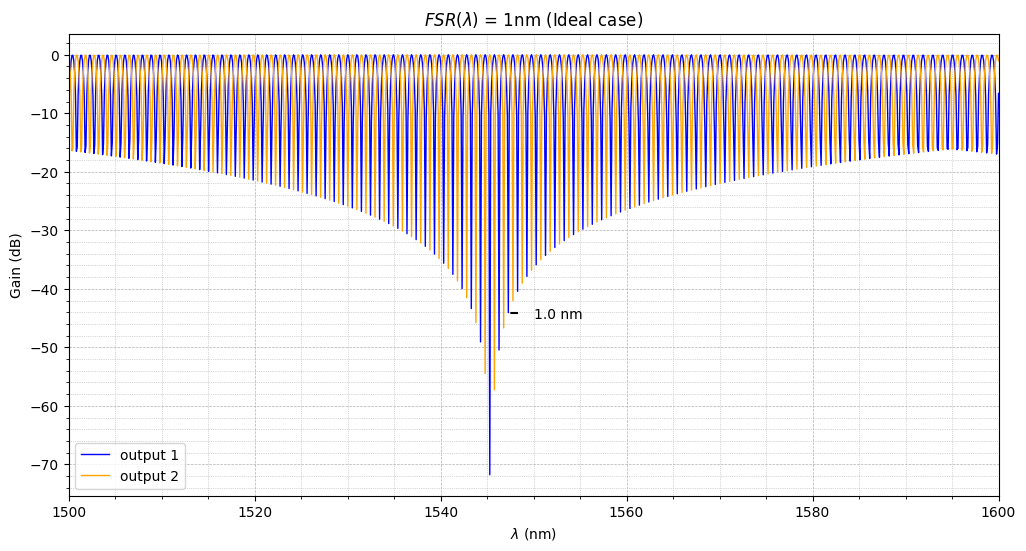

In [11]:
min_indices, _ = find_peaks(-np.array(gain_1nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[50:52]  
    x_min_1, x_min_2 = gain_1nm['wavelength'][min_1] / nm, gain_1nm['wavelength'][min_2] / nm
    y_min = gain_1nm['TE gain (dB)'][min_2]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_1nm['wavelength']/nm , gain_1nm['TE gain (dB)'], lw=1, label='output 1', color='blue')
    plt.plot(gain_2_1nm['wavelength']/nm , gain_2_1nm['TE gain (dB)'], lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1550, -45, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 1nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm', bbox_inches='tight')
    plt.show()

In [12]:
FSR_1_1nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_1nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_1nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_1nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_1nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_1nm['TE free spectral range (m)'])  

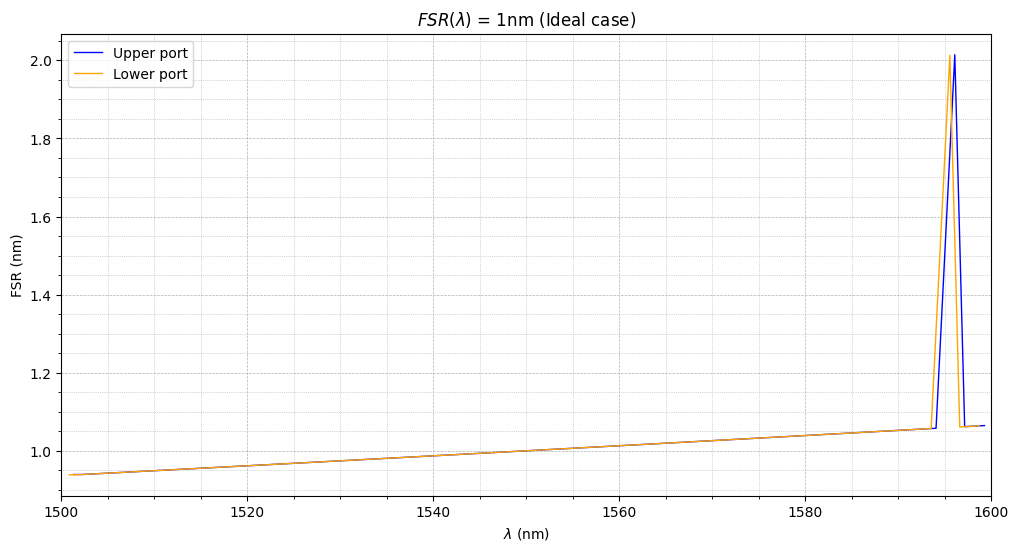

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 1nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda) = 10nm$

In [14]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_2')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L + delta_L[1])
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

In [15]:
interApi.setposition('wg_2', 0, 100)

In [16]:
# connection

interApi.connect("coupler_1", "port 4", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port 2")


1.0

In [17]:
interApi.run()

In [18]:
gain_10nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_10nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_8012\3368342393.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1551, y_min-8, f'{float(x_min_1 - x_min_2):.1f} nm')


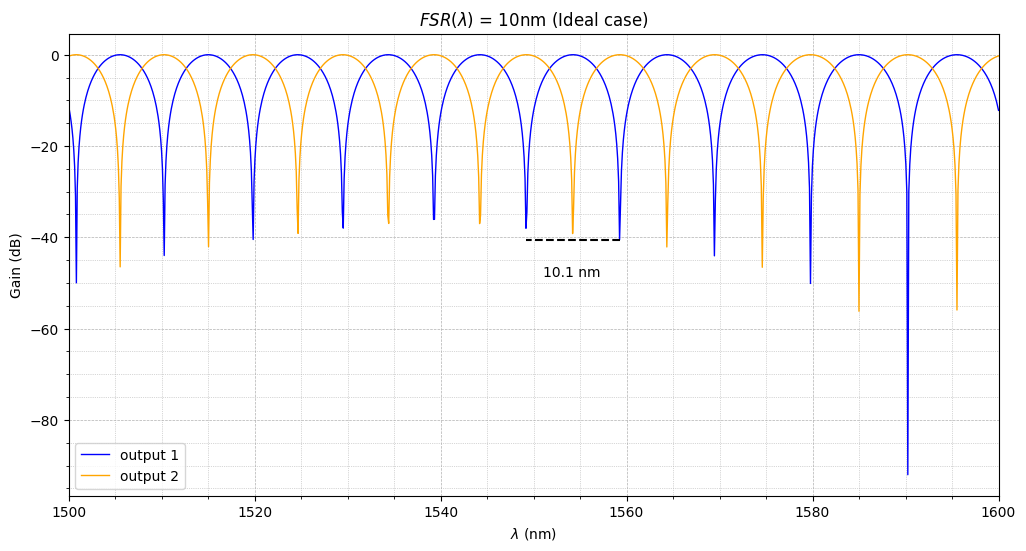

In [19]:
min_indices, _ = find_peaks(-np.array(gain_10nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[3:5]  
    x_min_1, x_min_2 = gain_10nm['wavelength'][min_1] / nm, gain_10nm['wavelength'][min_2] / nm
    y_min = gain_10nm['TE gain (dB)'][min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_10nm['wavelength']/nm , gain_10nm['TE gain (dB)'], lw=1, label='output 1', color='blue')
    plt.plot(gain_2_10nm['wavelength']/nm , gain_2_10nm['TE gain (dB)'], lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1551, y_min-8, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 10nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_10nm', bbox_inches='tight')
    plt.show()

In [20]:
FSR_1_10nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_10nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_10nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_10nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_10nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_10nm['TE free spectral range (m)'])  

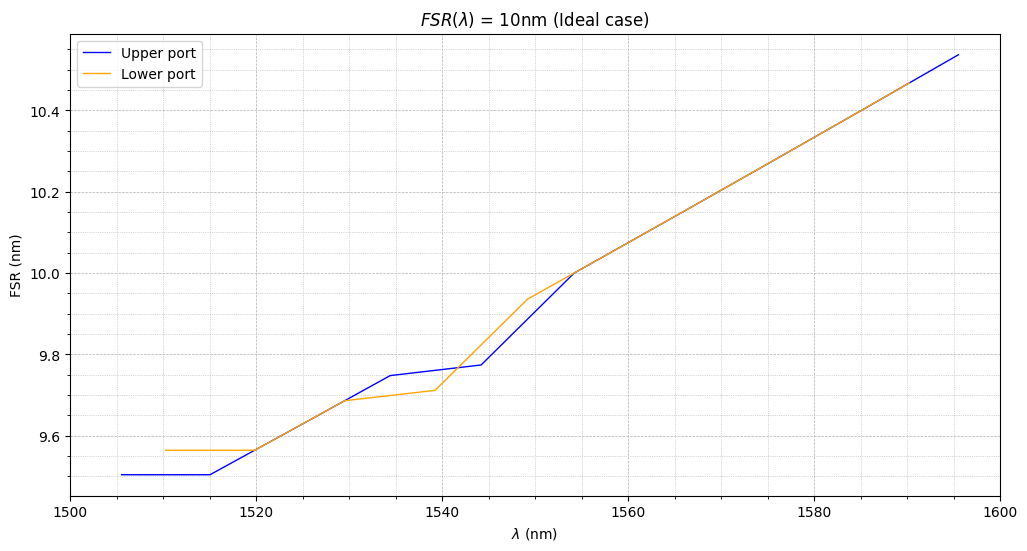

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 10nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_10nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda) = 20nm$

In [22]:
interApi.switchtolayout()
interApi.select('wg_2')
interApi.delete()

interApi.addelement('Straight Waveguide')
interApi.set('name', 'wg_2')
interApi.set('frequency', (c/(wavelength)))
interApi.set('length', L + delta_L[2])
interApi.set('effective index 1', neff)
interApi.set('group index 1', ng)

In [23]:
interApi.setposition('wg_2', 0, 100)

In [24]:
# connection

interApi.connect("coupler_1", "port 4", "wg_2", "port 1")
interApi.connect("wg_2", "port 2", "coupler_2", "port 2")


1.0

In [25]:
interApi.run()

In [26]:
gain_20nm = interApi.getresult("ONA", "input 1/mode 1/gain")

gain_2_20nm = interApi.getresult("ONA", "input 2/mode 1/gain")

C:\Users\alves\AppData\Local\Temp\ipykernel_8012\3195829107.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1548, y_min-10, f'{float(x_min_1 - x_min_2):.1f} nm')


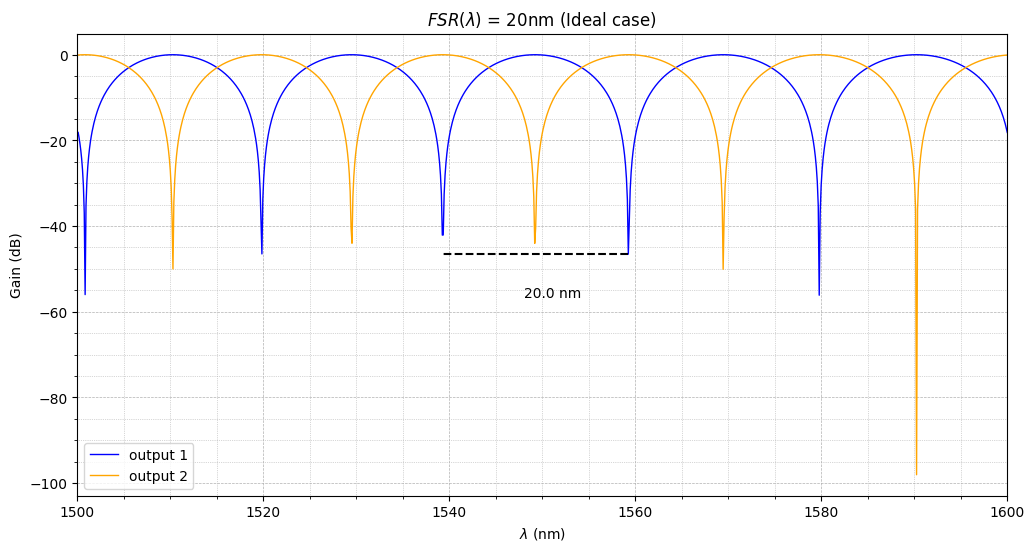

In [27]:
min_indices, _ = find_peaks(-np.array(gain_20nm['TE gain (dB)']))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[1:3] 
    x_min_1, x_min_2 = gain_20nm['wavelength'][min_1] / nm, gain_20nm['wavelength'][min_2] / nm
    y_min = gain_20nm['TE gain (dB)'][min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(gain_20nm['wavelength'] / nm, gain_20nm['TE gain (dB)'], lw=1, label='output 1', color='blue')
    plt.plot(gain_2_20nm['wavelength'] / nm, gain_2_20nm['TE gain (dB)'], lw=1, label='output 2', color='orange')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1548, y_min-10, f'{float(x_min_1 - x_min_2):.1f} nm')

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 20nm (Ideal case)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_20nm', bbox_inches='tight')

    plt.show()

In [28]:
FSR_1_20nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_20nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_20nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_20nm['TE free spectral range (m)'])

wavelength_2 = np.array(FSR_2_20nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_20nm['TE free spectral range (m)'])  

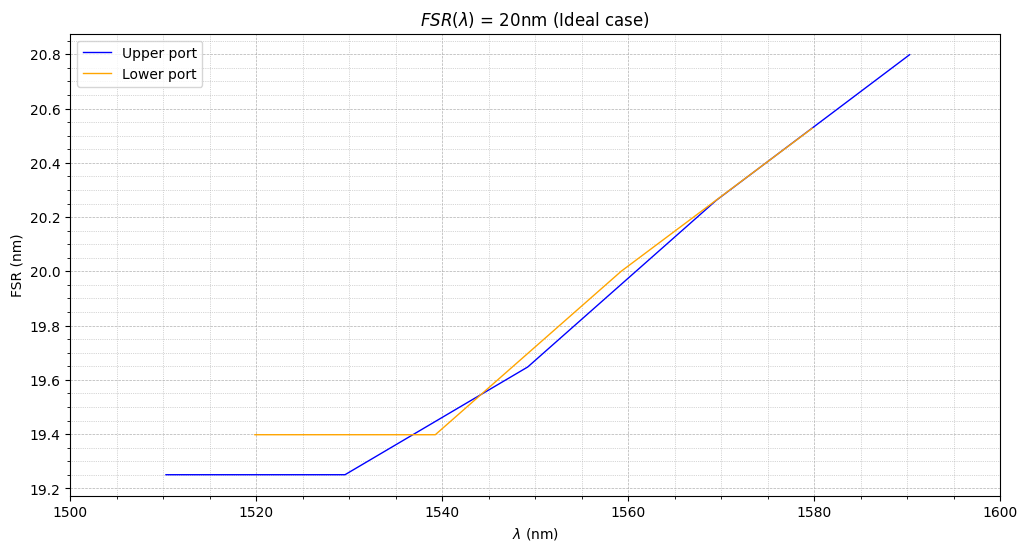

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=1, label='Upper port', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=1, label='Lower port', color='orange')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 20nm (Ideal case)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_20nm_x_wvlength', bbox_inches='tight')
plt.show()

# All cases

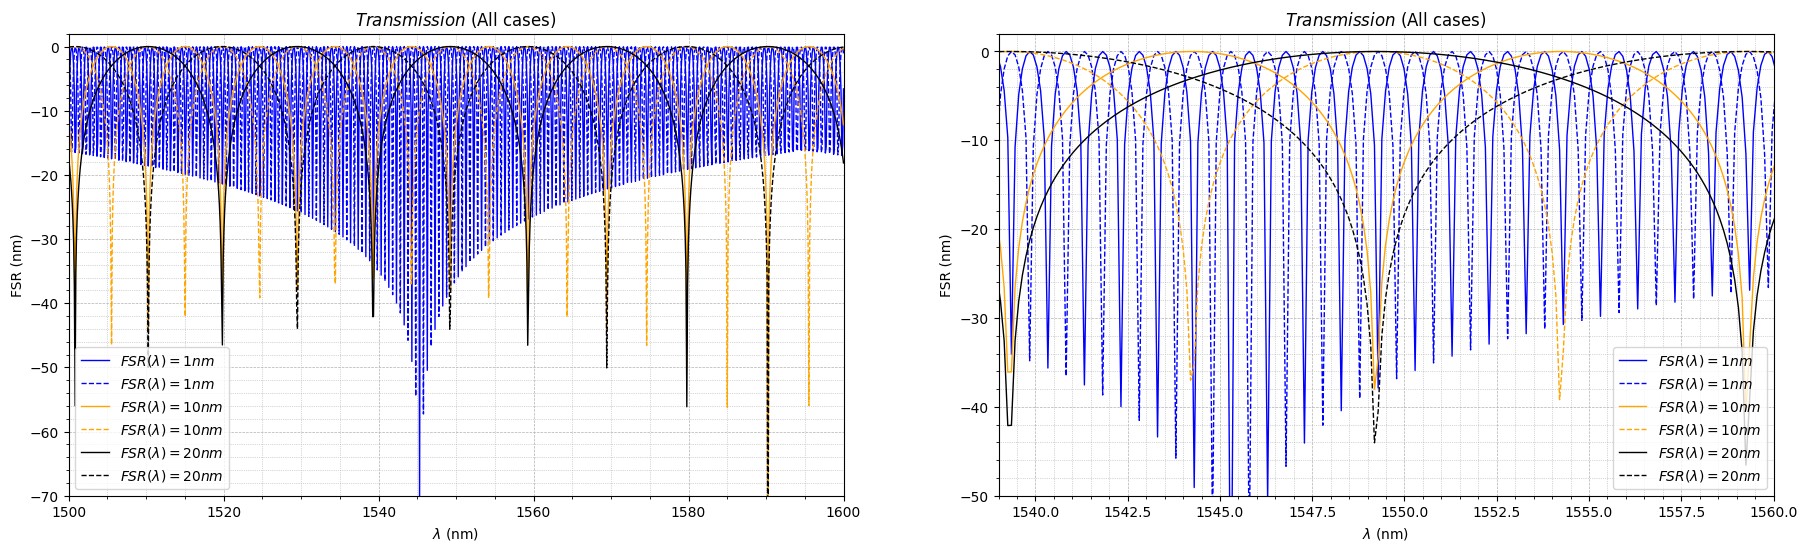

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(22, 6))

axs[0].plot(gain_1nm['wavelength'] / nm, gain_1nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=1nm$', color='blue')
axs[0].plot(gain_2_1nm['wavelength'] / nm, gain_2_1nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=1nm$', color='blue')

axs[0].plot(gain_10nm['wavelength'] / nm, gain_10nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=10nm$', color='orange')
axs[0].plot(gain_2_10nm['wavelength'] / nm, gain_2_10nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=10nm$', color='orange')

axs[0].plot(gain_20nm['wavelength'] / nm, gain_20nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=20nm$', color='black')
axs[0].plot(gain_2_20nm['wavelength'] / nm, gain_2_20nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=20nm$', color='black')

axs[0].set_xlabel('$\lambda$ (nm)')
axs[0].set_ylabel('FSR (nm)')
axs[0].set_xlim([wvlngth_start/nm, wvlngth_stop/nm])
axs[0].set_ylim([-70, 2])
    
axs[0].set_title('$Transmission$ (All cases)')
axs[0].minorticks_on()
axs[0].grid(which='both', linestyle='--', linewidth=0.5)  
axs[0].grid(which='minor', linestyle=':', linewidth=0.5) 

axs[0].legend(loc='best')

axs[1].plot(gain_1nm['wavelength'] / nm, gain_1nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=1nm$', color='blue')
axs[1].plot(gain_2_1nm['wavelength'] / nm, gain_2_1nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=1nm$', color='blue')

axs[1].plot(gain_10nm['wavelength'] / nm, gain_10nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=10nm$', color='orange')
axs[1].plot(gain_2_10nm['wavelength'] / nm, gain_2_10nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=10nm$', color='orange')

axs[1].plot(gain_20nm['wavelength'] / nm, gain_20nm['TE gain (dB)'], lw=1, label='$FSR(\lambda)=20nm$', color='black')
axs[1].plot(gain_2_20nm['wavelength'] / nm, gain_2_20nm['TE gain (dB)'], lw=1, ls = '--', label='$FSR(\lambda)=20nm$', color='black')

axs[1].set_xlabel('$\lambda$ (nm)')
axs[1].set_ylabel('FSR (nm)')
axs[1].set_xlim([1539, 1560])
axs[1].set_ylim([-50, 2])
    
axs[1].set_title('$Transmission$ (All cases)')
axs[1].minorticks_on()
axs[1].grid(which='both', linestyle='--', linewidth=0.5)  
axs[1].grid(which='minor', linestyle=':', linewidth=0.5) 

axs[1].legend(loc='best')

plt.savefig('FSR_1_10_20nm_Transmission', bbox_inches='tight')

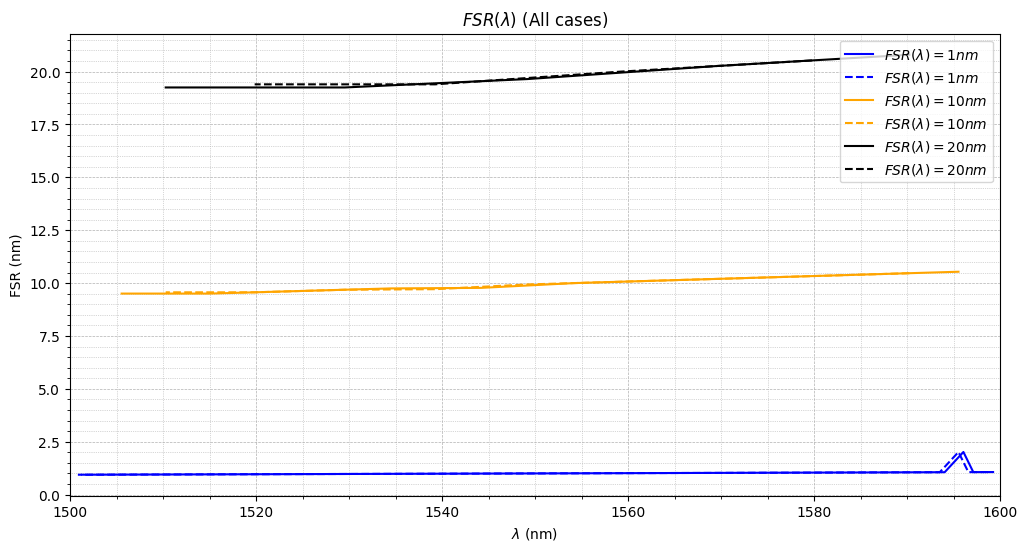

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(FSR_1_1nm['wavelength'] / nm, FSR_1_1nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=1nm$', color='blue')
plt.plot(FSR_2_1nm['wavelength'] / nm, FSR_2_1nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=1nm$', color='blue')

plt.plot(FSR_1_10nm['wavelength'] / nm, FSR_1_10nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=10nm$', color='orange')
plt.plot(FSR_2_10nm['wavelength'] / nm, FSR_2_10nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=10nm$', color='orange')

plt.plot(FSR_1_20nm['wavelength'] / nm, FSR_1_20nm['TE free spectral range (m)']/nm, lw=1.5, label='$FSR(\lambda)=20nm$', color='black')
plt.plot(FSR_2_20nm['wavelength'] / nm, FSR_2_20nm['TE free spectral range (m)']/nm, lw=1.5, ls = '--', label='$FSR(\lambda)=20nm$', color='black')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ (All cases)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1_10_20nm_x_wvlength', bbox_inches='tight')
plt.show()